**Task-1:- Perform image compression operation on an image.**

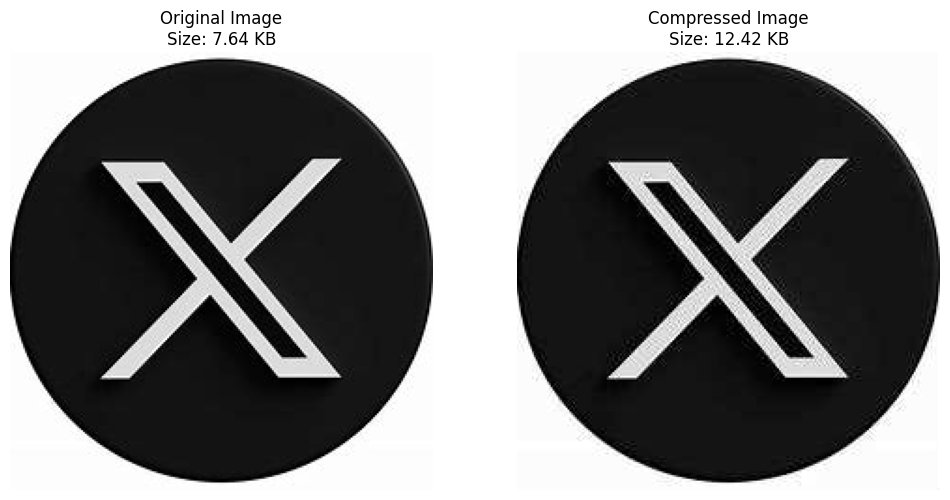

MSE: 48.6057, PSNR: 31.26 dB
Original File Size: 7.64 KB, Compressed File Size: 12.42 KB


In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from skimage.metrics import mean_squared_error, peak_signal_noise_ratio

# Function to perform block-wise DCT
def blockwise_dct(image, block_size=8):
    h, w = image.shape
    dct_image = np.zeros_like(image, dtype=np.float32)
    for i in range(0, h, block_size):
        for j in range(0, w, block_size):
            block = image[i:i + block_size, j:j + block_size]
            dct_block = cv2.dct(np.float32(block))
            dct_image[i:i + block_size, j:j + block_size] = dct_block
    return dct_image

# Function to perform block-wise Inverse DCT
def blockwise_idct(dct_image, block_size=8):
    h, w = dct_image.shape
    image_reconstructed = np.zeros_like(dct_image, dtype=np.float32)
    for i in range(0, h, block_size):
        for j in range(0, w, block_size):
            dct_block = dct_image[i:i + block_size, j:j + block_size]
            block = cv2.idct(dct_block)
            image_reconstructed[i:i + block_size, j:j + block_size] = block
    return image_reconstructed

# Function to quantize DCT coefficients block-wise
def blockwise_quantize_dct(dct_image, quant_matrix, block_size=8):
    h, w = dct_image.shape
    quantized_dct = np.zeros_like(dct_image)
    for i in range(0, h, block_size):
        for j in range(0, w, block_size):
            block = dct_image[i:i + block_size, j:j + block_size]
            quantized_block = np.round(block / quant_matrix)
            quantized_dct[i:i + block_size, j:j + block_size] = quantized_block
    return quantized_dct

# Function to dequantize the DCT coefficients block-wise
def blockwise_dequantize_dct(quantized_dct, quant_matrix, block_size=8):
    h, w = quantized_dct.shape
    dequantized_dct = np.zeros_like(quantized_dct)
    for i in range(0, h, block_size):
        for j in range(0, w, block_size):
            block = quantized_dct[i:i + block_size, j:j + block_size]
            dequantized_block = block * quant_matrix
            dequantized_dct[i:i + block_size, j:j + block_size] = dequantized_block
    return dequantized_dct

# Load and preprocess image
image_path = "logo.jpg"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
original_file_size = os.path.getsize(image_path) / 1024  # in KB

h, w = image.shape
new_h = (h + 7) // 8 * 8
new_w = (w + 7) // 8 * 8
padded_image = cv2.copyMakeBorder(image, 0, new_h - h, 0, new_w - w, cv2.BORDER_CONSTANT, value=0)

# JPEG-like quantization matrix
quant_matrix = np.array([
    [16, 11, 10, 16, 24, 40, 51, 61],
    [12, 12, 14, 19, 26, 58, 60, 55],
    [14, 13, 16, 24, 40, 57, 69, 56],
    [14, 17, 22, 29, 51, 87, 80, 62],
    [18, 22, 37, 56, 68, 109, 103, 77],
    [24, 35, 55, 64, 81, 104, 113, 92],
    [49, 64, 78, 87, 103, 121, 120, 101],
    [72, 92, 95, 98, 112, 100, 103, 99]
])

# Apply compression pipeline
dct_image = blockwise_dct(padded_image)
quantized_dct = blockwise_quantize_dct(dct_image, quant_matrix)
dequantized_dct = blockwise_dequantize_dct(quantized_dct, quant_matrix)
image_reconstructed = blockwise_idct(dequantized_dct)[:h, :w]
image_reconstructed = np.clip(image_reconstructed, 0, 255).astype(np.uint8)

# Save the compressed image
compressed_image_path = "compressed_logo.jpg"
cv2.imwrite(compressed_image_path, image_reconstructed)
compressed_file_size = os.path.getsize(compressed_image_path) / 1024  # in KB

# Compute evaluation metrics
mse = mean_squared_error(image, image_reconstructed)
psnr = peak_signal_noise_ratio(image, image_reconstructed, data_range=255)

# Display images and metrics
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title(f'Original Image\nSize: {original_file_size:.2f} KB')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(image_reconstructed, cmap='gray')
plt.title(f'Compressed Image\nSize: {compressed_file_size:.2f} KB')
plt.axis('off')
plt.show()
print(f'MSE: {mse:.4f}, PSNR: {psnr:.2f} dB\nOriginal File Size: {original_file_size:.2f} KB, Compressed File Size: {compressed_file_size:.2f} KB')


Size was increasing in previous code.

Reason for increased size in earlier code:-

1.original image (image) is stored as uint8 (1 byte per pixel) and DCT tranformation stored as are stored as float32 (4 bytes per pixel).

**Solution:-** We have to Store quantized_dct as int8

2 . we were storing the reconstructed image as PNG, it may become larger due to lossless compression.

**Solution:-** Save as JPEG compressed cv2.imwrite("compressed.jpg", image_reconstructed, [cv2.IMWRITE_JPEG_QUALITY, 50])


Original Image Shape: (512, 512), Size: 262144 bytes
Padded Image Shape: (512, 512), Size: 262144 bytes
Quantized DCT Shape: (512, 512), Size: 262144 bytes
Reconstructed Image Shape (with padding): (512, 512)
Final JPEG File Size (Padded Image): 17961 bytes
Final JPEG File Size (Cropped Image): 17961 bytes
Compression Ratio (Original / JPEG Cropped): 14.60x


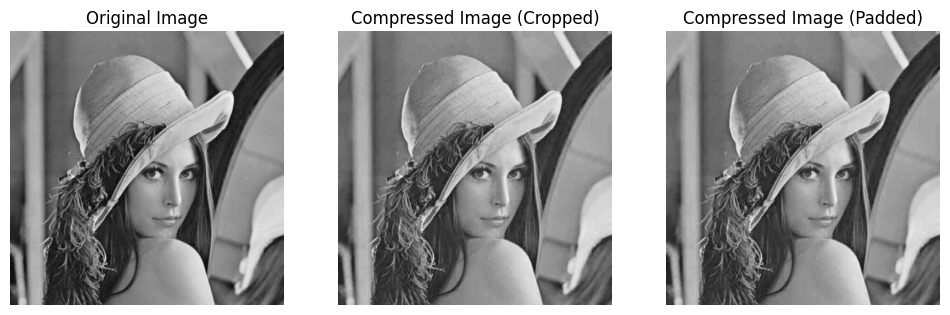

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function to perform block-wise DCT
def blockwise_dct(image, block_size=8):
    """Applies DCT block-wise to an image."""
    h, w = image.shape
    dct_image = np.zeros_like(image, dtype=np.float32)

    for i in range(0, h, block_size):
        for j in range(0, w, block_size):
            block = image[i:i + block_size, j:j + block_size]
            dct_block = cv2.dct(np.float32(block))
            dct_image[i:i + block_size, j:j + block_size] = dct_block

    return dct_image

# Function to perform block-wise Inverse DCT
def blockwise_idct(dct_image, block_size=8):
    """Applies Inverse DCT block-wise to an image."""
    h, w = dct_image.shape
    image_reconstructed = np.zeros_like(dct_image, dtype=np.float32)

    for i in range(0, h, block_size):
        for j in range(0, w, block_size):
            dct_block = dct_image[i:i + block_size, j:j + block_size]
            block = cv2.idct(dct_block)
            image_reconstructed[i:i + block_size, j:j + block_size] = block

    return image_reconstructed

# Function to apply quantization
def blockwise_quantize_dct(dct_image, quant_matrix, block_size=8):
    """Quantizes the DCT coefficients block-wise."""
    h, w = dct_image.shape
    quantized_dct = np.zeros_like(dct_image, dtype=np.int8)  # Using int8 for better compression

    for i in range(0, h, block_size):
        for j in range(0, w, block_size):
            block = dct_image[i:i + block_size, j:j + block_size]
            quantized_block = np.round(block / quant_matrix).astype(np.int8)  # Convert to int8
            quantized_dct[i:i + block_size, j:j + block_size] = quantized_block

    return quantized_dct

# Function to dequantize
def blockwise_dequantize_dct(quantized_dct, quant_matrix, block_size=8):
    """Dequantizes the DCT coefficients block-wise."""
    h, w = quantized_dct.shape
    dequantized_dct = np.zeros_like(quantized_dct, dtype=np.float32)

    for i in range(0, h, block_size):
        for j in range(0, w, block_size):
            block = quantized_dct[i:i + block_size, j:j + block_size]
            dequantized_block = block * quant_matrix  # Dequantization
            dequantized_dct[i:i + block_size, j:j + block_size] = dequantized_block

    return dequantized_dct

# Load the image in grayscale
image_path = "Lenna.jpeg"
image = cv2.imread("girl.jpeg", cv2.IMREAD_GRAYSCALE)

# Pad the image to make its dimensions a multiple of 8
h, w = image.shape
new_h = (h + 7) // 8 * 8
new_w = (w + 7) // 8 * 8
padded_image = cv2.copyMakeBorder(image, 0, new_h - h, 0, new_w - w, cv2.BORDER_CONSTANT, value=0)

# Define an 8x8 quantization matrix (JPEG-like) with increased compression
quant_matrix = np.array([
    [16, 11, 10, 16, 24, 40, 51, 61],
    [12, 12, 14, 19, 26, 58, 60, 55],
    [14, 13, 16, 24, 40, 57, 69, 56],
    [14, 17, 22, 29, 51, 87, 80, 62],
    [18, 22, 37, 56, 68, 109, 103, 77],
    [24, 35, 55, 64, 81, 104, 113, 92],
    [49, 64, 78, 87, 103, 121, 120, 101],
    [72, 92, 95, 98, 112, 100, 103, 99]
]) * 2  # Increasing quantization factor for more compression

# Apply block-wise DCT
dct_image = blockwise_dct(padded_image)

# Quantize the DCT coefficients
quantized_dct = blockwise_quantize_dct(dct_image, quant_matrix)

# Dequantize to get approximate DCT coefficients
dequantized_dct = blockwise_dequantize_dct(quantized_dct, quant_matrix)

# Reconstruct the image using Inverse DCT
image_reconstructed = blockwise_idct(dequantized_dct)

# Convert to uint8 format
image_reconstructed = np.clip(image_reconstructed, 0, 255).astype(np.uint8)

# Save the **padded** compressed image as JPEG
compressed_padded_image_path = "compressed_padded_image.jpg"
cv2.imwrite(compressed_padded_image_path, image_reconstructed, [cv2.IMWRITE_JPEG_QUALITY, 50])

# Also crop back to the original image size for visualization
image_reconstructed_cropped = image_reconstructed[:h, :w]

# Save cropped compressed image as JPEG
compressed_cropped_image_path = "compressed_cropped_image.jpg"
cv2.imwrite(compressed_cropped_image_path, image_reconstructed_cropped, [cv2.IMWRITE_JPEG_QUALITY, 50])

# Print sizes for comparison
original_size = image.nbytes  # Original image in bytes
padded_size = padded_image.nbytes  # Padded image in bytes
compressed_size = quantized_dct.nbytes  # Since stored as int8, 1 byte per pixel
jpeg_padded_size = len(open(compressed_padded_image_path, "rb").read())  # Padded compressed file size
jpeg_cropped_size = len(open(compressed_cropped_image_path, "rb").read())  # Cropped compressed file size

print(f"Original Image Shape: {image.shape}, Size: {original_size} bytes")
print(f"Padded Image Shape: {padded_image.shape}, Size: {padded_size} bytes")
print(f"Quantized DCT Shape: {quantized_dct.shape}, Size: {compressed_size} bytes")
print(f"Reconstructed Image Shape (with padding): {image_reconstructed.shape}")
print(f"Final JPEG File Size (Padded Image): {jpeg_padded_size} bytes")
print(f"Final JPEG File Size (Cropped Image): {jpeg_cropped_size} bytes")
print(f"Compression Ratio (Original / JPEG Cropped): {original_size / jpeg_cropped_size:.2f}x")

# Display the images
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(image_reconstructed, cmap='gray')
plt.title('Compressed Image (Cropped)')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(image_reconstructed_cropped, cmap='gray')
plt.title('Compressed Image (Padded)')
plt.axis('off')

plt.show()



Image Size Comparison:
Original Image Size: 7.64 KB
JPEG Compressed Size: 6.11 KB (Lossy)
PNG Compressed Size: 30.66 KB (Lossless)

Image Dimensions and Pixel Count:
Original Image: 226x234 (52884 pixels)
JPEG Compressed Image: 226x234 (52884 pixels)
PNG Compressed Image: 226x234 (52884 pixels)

MSE and PSNR Comparison:
MSE (JPEG): 18.22, PSNR (JPEG): 35.53 dB
MSE (PNG): 0.52, PSNR (PNG): 50.98 dB


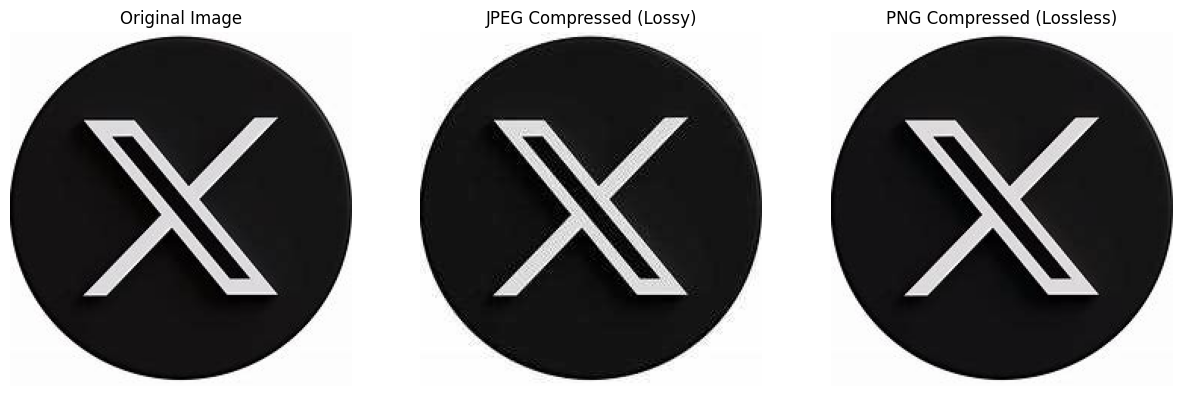

In [ ]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

image_path = "logo.jpg"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

jpeg_compressed_path = "compressed_image_lossy.jpg"
cv2.imwrite(jpeg_compressed_path, image, [int(cv2.IMWRITE_JPEG_QUALITY), 50])

png_compressed_path = "compressed_image_lossless.png"
cv2.imwrite(png_compressed_path, image, [int(cv2.IMWRITE_PNG_COMPRESSION), 9])

jpeg_compressed = cv2.imread(jpeg_compressed_path)
jpeg_compressed = cv2.cvtColor(jpeg_compressed, cv2.COLOR_BGR2RGB)

png_compressed = cv2.imread(png_compressed_path)
png_compressed = cv2.cvtColor(png_compressed, cv2.COLOR_BGR2RGB)

original_size = os.path.getsize(image_path)
jpeg_size = os.path.getsize(jpeg_compressed_path)
png_size = os.path.getsize(png_compressed_path)

original_height, original_width, _ = image.shape
jpeg_height, jpeg_width, _ = jpeg_compressed.shape
png_height, png_width, _ = png_compressed.shape

original_pixels = original_height * original_width
jpeg_pixels = jpeg_height * jpeg_width
png_pixels = png_height * png_width

def mse(imageA, imageB):
    return np.mean((imageA - imageB) ** 2)

def psnr(imageA, imageB):
    mse_value = mse(imageA, imageB)
    if mse_value == 0:
        return float('inf')
    max_pixel = 255.0
    return 10 * np.log10((max_pixel ** 2) / mse_value)

mse_jpeg = mse(image, jpeg_compressed)
mse_png = mse(image, png_compressed)

psnr_jpeg = psnr(image, jpeg_compressed)
psnr_png = psnr(image, png_compressed)

print("\nImage Size Comparison:")
print(f"Original Image Size: {original_size / 1024:.2f} KB")
print(f"JPEG Compressed Size: {jpeg_size / 1024:.2f} KB (Lossy)")
print(f"PNG Compressed Size: {png_size / 1024:.2f} KB (Lossless)")

print("\nImage Dimensions and Pixel Count:")
print(f"Original Image: {original_width}x{original_height} ({original_pixels} pixels)")
print(f"JPEG Compressed Image: {jpeg_width}x{jpeg_height} ({jpeg_pixels} pixels)")
print(f"PNG Compressed Image: {png_width}x{png_height} ({png_pixels} pixels)")

print("\nMSE and PSNR Comparison:")
print(f"MSE (JPEG): {mse_jpeg:.2f}, PSNR (JPEG): {psnr_jpeg:.2f} dB")
print(f"MSE (PNG): {mse_png:.2f}, PSNR (PNG): {psnr_png:.2f} dB")

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(image)
axes[0].set_title("Original Image")
axes[0].axis("off")

axes[1].imshow(jpeg_compressed)
axes[1].set_title("JPEG Compressed (Lossy)")
axes[1].axis("off")

axes[2].imshow(png_compressed)
axes[2].set_title("PNG Compressed (Lossless)")
axes[2].axis("off")

plt.show()


**Task-2:- Apply convolution neural networks (CNN)  on MNIST and CIFAR-10 datasets.**

In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split

ON MNIST

In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

In [ ]:
x = np.concatenate((x_train, x_test), axis=0)
y = np.concatenate((y_train, y_test), axis=0)

In [ ]:
x = x / 255.0
x = np.expand_dims(x, axis=-1)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [ ]:
def create_mnist_model():
    model = keras.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
mnist_model = create_mnist_model()
mnist_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dense (Dense)               (None, 128)               2

In [12]:
history_mnist = mnist_model.fit(x_train, y_train, epochs=50, batch_size=32, validation_data=(x_test, y_test))


Epoch 1/50
1750/1750 [==============================] - 27s 9ms/step - loss: 0.1328 - accuracy: 0.9595 - val_loss: 0.0499 - val_accuracy: 0.9837
Epoch 2/50
1750/1750 [==============================] - 14s 8ms/step - loss: 0.0435 - accuracy: 0.9866 - val_loss: 0.0475 - val_accuracy: 0.9854
Epoch 3/50
1750/1750 [==============================] - 14s 8ms/step - loss: 0.0288 - accuracy: 0.9908 - val_loss: 0.0368 - val_accuracy: 0.9888
Epoch 4/50
1750/1750 [==============================] - 13s 8ms/step - loss: 0.0204 - accuracy: 0.9934 - val_loss: 0.0327 - val_accuracy: 0.9901
Epoch 5/50
1750/1750 [==============================] - 13s 8ms/step - loss: 0.0169 - accuracy: 0.9946 - val_loss: 0.0397 - val_accuracy: 0.9882
Epoch 6/50
1750/1750 [==============================] - 14s 8ms/step - loss: 0.0122 - accuracy: 0.9962 - val_loss: 0.0398 - val_accuracy: 0.9893
Epoch 7/50
1750/1750 [==============================] - 13s 8ms/step - loss: 0.0098 - accuracy: 0.9970 - val_loss: 0.0413 - val_ac

In [ ]:
y_pred_mnist = np.argmax(mnist_model.predict(x_test), axis=1)
print(classification_report(y_test, y_pred_mnist))

438/438 [==============================] - 2s 3ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1343
           1       0.99      1.00      0.99      1600
           2       0.99      0.98      0.99      1380
           3       0.99      0.99      0.99      1433
           4       0.99      0.99      0.99      1295
           5       1.00      0.99      0.99      1273
           6       0.99      1.00      1.00      1396
           7       0.99      0.99      0.99      1503
           8       0.99      0.99      0.99      1357
           9       0.99      0.99      0.99      1420

    accuracy                           0.99     14000
   macro avg       0.99      0.99      0.99     14000
weighted avg       0.99      0.99      0.99     14000



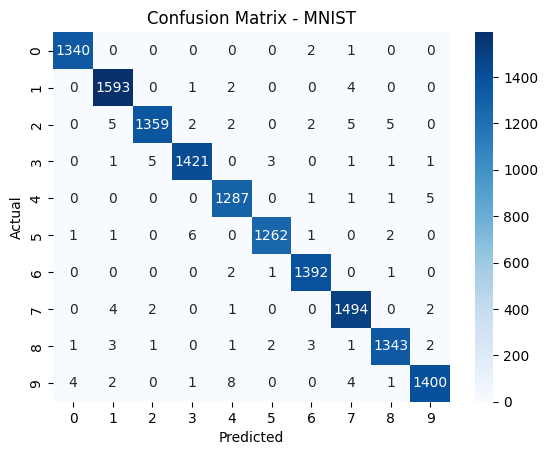

In [ ]:
cm_mnist = confusion_matrix(y_test, y_pred_mnist)
sns.heatmap(cm_mnist, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - MNIST')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

438/438 [==============================] - 2s 3ms/step


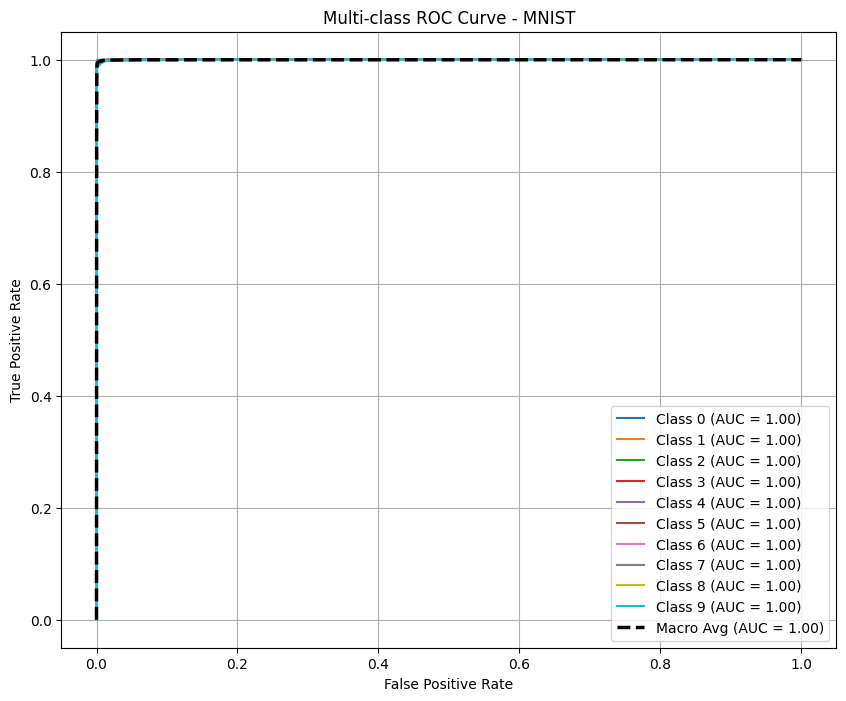

<Figure size 640x480 with 0 Axes>

In [ ]:
y_test_binarized = label_binarize(y_test, classes=np.arange(10))
y_pred_proba_mnist = mnist_model.predict(x_test)

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(10):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_proba_mnist[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(10)]))
mean_tpr = np.zeros_like(all_fpr)

for i in range(10):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= 10
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.figure(figsize=(10, 8))
for i in range(10):
    plt.plot(fpr[i], tpr[i], lw=1.5, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot(fpr["macro"], tpr["macro"], color='black', linestyle='--', lw=2.5, label=f'Macro Avg (AUC = {roc_auc["macro"]:.2f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve - MNIST')
plt.legend(loc='best')
plt.grid()
plt.show()

plt.savefig("mnist_roc_curve.png")


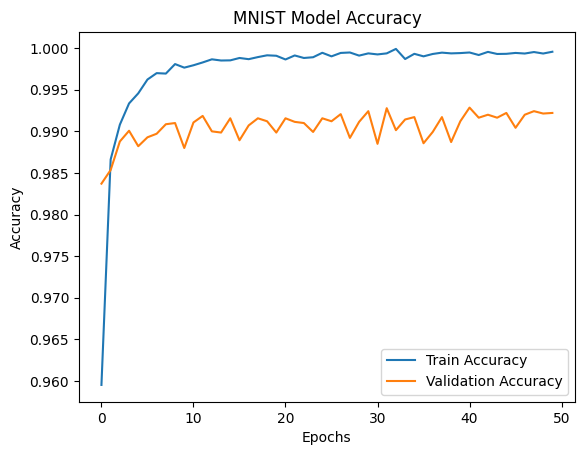

In [20]:
history_mnist1 = history_mnist.history
plt.plot(history_mnist1['accuracy'], label='Train Accuracy')
plt.plot(history_mnist1['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title("MNIST Model Accuracy")
plt.show()


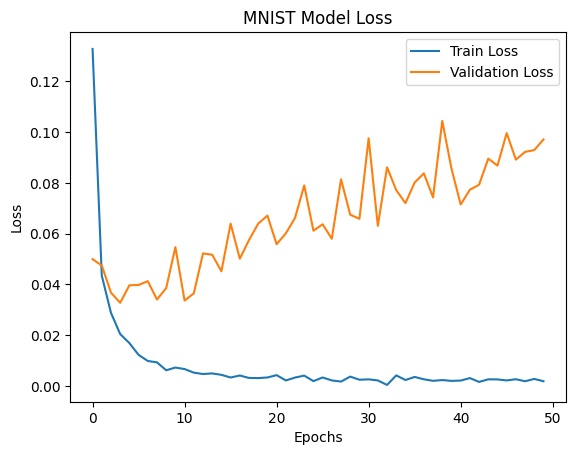

In [38]:
history_mnist1 = history_mnist.history
plt.plot(history_mnist1['loss'], label='Train Loss')
plt.plot(history_mnist1['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title("MNIST Model Loss")
plt.show()

ON CIFAR-10

In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

In [ ]:
x = np.concatenate((x_train, x_test), axis=0)
y = np.concatenate((y_train, y_test), axis=0)

In [ ]:
x = x / 255.0

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [ ]:
def create_cifar10_model():
    model = keras.Sequential([
        layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(10, activation='softmax')
    ])
    
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [26]:
cifar10_model = create_cifar10_model()
cifar10_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        1792      
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 batch_normalization_1 (Batc  (None, 16, 16, 128)      512       
 hNormalization)                                                 
                                                      

In [27]:
history_cifar10=cifar10_model.fit(x_train, y_train, epochs=50, batch_size=64, validation_data=(x_test, y_test))

Epoch 1/50
750/750 [==============================] - 17s 19ms/step - loss: 1.5823 - accuracy: 0.4417 - val_loss: 1.4002 - val_accuracy: 0.5275
Epoch 2/50
750/750 [==============================] - 11s 15ms/step - loss: 1.1464 - accuracy: 0.5950 - val_loss: 1.3344 - val_accuracy: 0.5675
Epoch 3/50
750/750 [==============================] - 11s 15ms/step - loss: 0.9483 - accuracy: 0.6696 - val_loss: 0.8718 - val_accuracy: 0.6881
Epoch 4/50
750/750 [==============================] - 12s 16ms/step - loss: 0.8061 - accuracy: 0.7205 - val_loss: 0.8984 - val_accuracy: 0.6917
Epoch 5/50
750/750 [==============================] - 12s 16ms/step - loss: 0.7045 - accuracy: 0.7547 - val_loss: 0.8139 - val_accuracy: 0.7193
Epoch 6/50
750/750 [==============================] - 11s 14ms/step - loss: 0.6129 - accuracy: 0.7883 - val_loss: 0.7425 - val_accuracy: 0.7471
Epoch 7/50
750/750 [==============================] - 11s 14ms/step - loss: 0.5266 - accuracy: 0.8158 - val_loss: 0.8498 - val_accuracy:

In [ ]:
y_pred_cifar10 = np.argmax(cifar10_model.predict(x_test), axis=1)
y_test_cifar10 = y_test.flatten()
print(classification_report(y_test_cifar10, y_pred_cifar10))

375/375 [==============================] - 2s 5ms/step
              precision    recall  f1-score   support

           0       0.79      0.85      0.82      1181
           1       0.90      0.88      0.89      1188
           2       0.67      0.78      0.72      1232
           3       0.63      0.64      0.64      1274
           4       0.76      0.72      0.74      1179
           5       0.79      0.59      0.68      1230
           6       0.73      0.90      0.81      1123
           7       0.86      0.80      0.83      1217
           8       0.85      0.88      0.87      1189
           9       0.91      0.81      0.86      1187

    accuracy                           0.78     12000
   macro avg       0.79      0.79      0.78     12000
weighted avg       0.79      0.78      0.78     12000



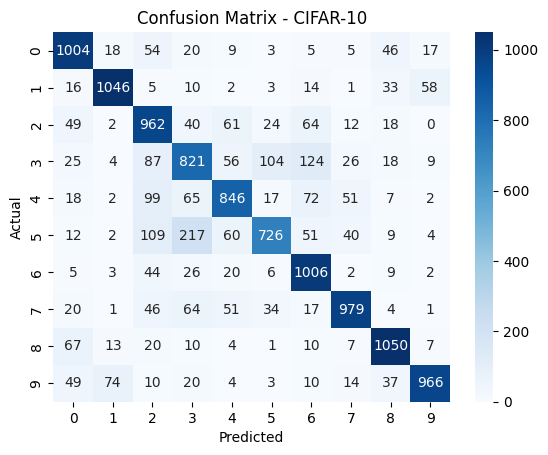

In [ ]:
cm_cifar10 = confusion_matrix(y_test_cifar10, y_pred_cifar10)
sns.heatmap(cm_cifar10, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - CIFAR-10')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

375/375 [==============================] - 2s 4ms/step


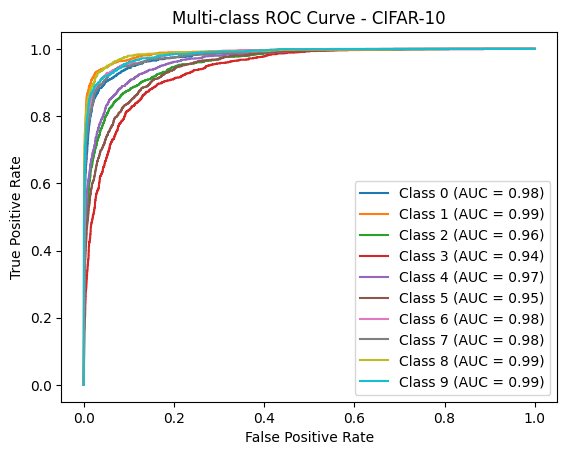

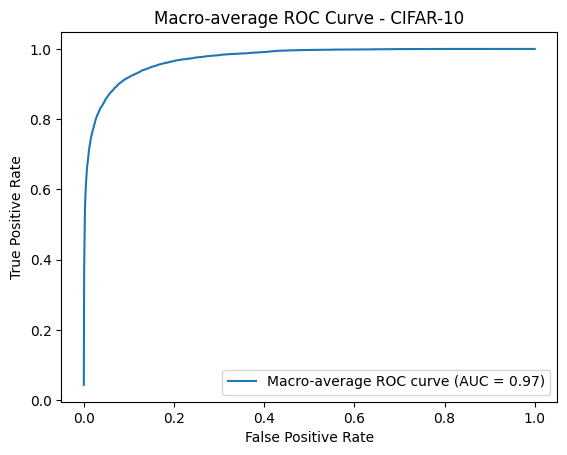

In [30]:
# Compute and plot ROC-AUC for multi-class classification
y_test_binarized = label_binarize(y_test_cifar10, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
y_pred_proba_cifar10 = cifar10_model.predict(x_test)
n_classes = y_test_binarized.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_proba_cifar10[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve - CIFAR-10')
plt.legend(loc='best')
plt.show()

# Compute macro-average ROC curve and AUC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.figure()
plt.plot(fpr["macro"], tpr["macro"], label=f'Macro-average ROC curve (AUC = {roc_auc["macro"]:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Macro-average ROC Curve - CIFAR-10')
plt.legend(loc='best')
plt.show()


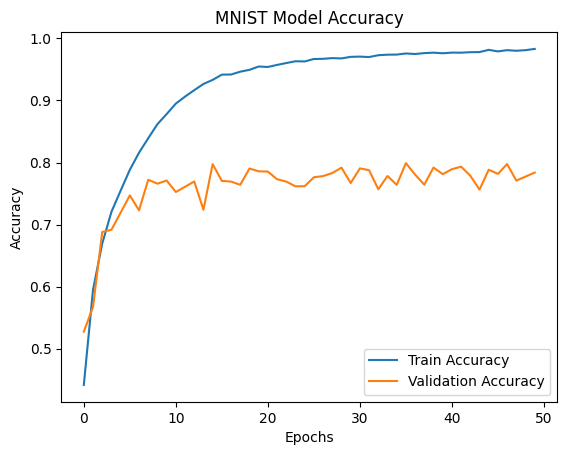

In [39]:
history_cifar10_1 = history_cifar10.history
plt.plot(history_cifar10_1['accuracy'], label='Train Accuracy')
plt.plot(history_cifar10_1['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title("MNIST Model Accuracy")
plt.show()


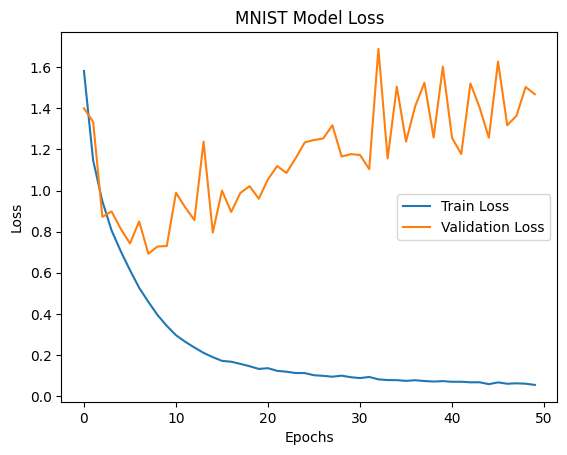

In [40]:
history_cifar10_1 = history_cifar10.history
plt.plot(history_cifar10_1['loss'], label='Train Loss')
plt.plot(history_cifar10_1['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title("MNIST Model Loss")
plt.show()